# Preprocessing data 

## 1. Preparations
### 1.1 Import required packages

In [14]:
# import rasterio
try:
    import rasterio
except:
    %pip install rasterio
    import rasterio

import rasterio.features
import rasterio.warp
from rasterio.windows import Window
from rasterio.features import geometry_mask
from rasterio.features import rasterize

In [6]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import json  # for saving patch metadata in JSON format

### 1.2 Set directories and file paths

In [7]:
# input directories
# raster data
gtif_dir = r"D:\Drohne\1_OHB\1_OHB_Normalbetrieb\3_OHB_Juli_2024\Outputs\RGB\GeoTIFF"
# class labels
shp_dir = r"G:\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles"

# output directories for patches
# as GeoTIFFs
output_gtif_dir = r"D:\MoSE\preprocessing\gtif_outputs"
# as NumpyArrays
output_nparr_dir = r"D:\MoSE\preprocessing\nparr_outputs"
# for JSON metadata
output_json_dir = r"D:\MoSE\preprocessing\json_outputs"

## 2. Create Patches
### 2.1 Set Hyperparameters

In [8]:
# exact paths to files
# raster data
gtif_name = "A01"
gtif_path = gtif_dir + r"\OHB_Abschnitt_01.tif"
# class labels
shp_path = shp_dir + r"\GSK_24_WGS84.shp"

In [9]:
# parameters for patches
PATCH_SIZE = 512 # 512x512 pixel per patch
STRIDE = 256 # 256 pixel overlap between patches

### 2.2 Label preparations and Class Coding

In [10]:
labels = gpd.read_file(shp_path)
labels["Elementtyp"].unique()

array(['Einzelstein', 'Wurzelstock', 'Steinverbauung', 'Totholz',
       'Steinriegel', 'Schotterbank', 'Schlamm_Sandinsel',
       'Sand_Schlammbank', 'Schotterinsel', None], dtype=object)

In [ ]:
# Remove labels without class 
labels_filtered = labels[labels["Elementtyp"].notnull()]
print(labels_filtered["Elementtyp"].unique())

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


Class coding

In [16]:
label_codes = { # assign a unique pixel value to each class (element type)
    "Einzelstein": 1,
    "Wurzelstock": 2,
    "Steinverbauung": 3,
    "Totholz": 4,
    "Steinriegel": 5,
    "Schotterbank": 6,
    "Schlamm_Sandinsel": 7,
    "Sand_Schlammbank": 8,
    "Schotterinsel": 9
}

In [103]:
label_codes.items()

dict_items([('Einzelstein', 1), ('Wurzelstock', 2), ('Steinverbauung', 3), ('Totholz', 4), ('Steinriegel', 5), ('Schotterbank', 6), ('Schlamm_Sandinsel', 7), ('Sand_Schlammbank', 8), ('Schotterinsel', 9)])

In [104]:
# dictionary
label_codes["Totholz"]

4

In [105]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

In [18]:
num_classes = len(label_codes)
num_classes

9

In [19]:
label_codes_path = os.path.join(output_json_dir, "label_codes.json")
with open(label_codes_path, "w") as json_file:
    json.dump(label_codes, json_file, indent=4)

### 2.3 Create the patch loop

In [ ]:
#######################################################
# 1. Load the GeoTIFF (orthophoto)
with rasterio.open(gtif_path) as src:
    # nparr_data = src.read() # reads raster data of the GeoTIFF as NumPy-Array
    gtif_width, gtif_height = src.width, src.height
    gtif_transform = src.transform  # transformation matrix (whole image)
    gtif_crs = src.crs  # coordinate system
    gtif_meta = src.meta.copy() # original metadata like coordinate system, resolution, datatype
    gtif_bounds = src.bounds
    #######################################################

    # 2. Transform labels to crs of the orthophoto
    labels_crs = labels_filtered.to_crs(gtif_crs)

    #######################################################
    # 3. LOOP for patches
    #######################################################

    # set patch-id to zero
    patch_id = 0 # unique counter

    # Loop over the image in steps of STRIDE (overlapping patches if STRIDE < PATCH_SIZE)
    for y in range(0, gtif_height, STRIDE): # vertical movement y (start point: 0, end point: height, steps: STRIDE)
        for x in range(0, gtif_width, STRIDE): # horizontal movement x (start point: 0, end point: width, steps: STRIDE)
            
            # 3.1 Define window (patch)
            window = Window(x, y, PATCH_SIZE, PATCH_SIZE) 
            # defines a patch/window with origin (x, y) and a size of PATCH_SIZExPATCH_SIZE 

            # 3.2 Calculate the transformation matrix for this patch
            patch_transform = src.window_transform(window) 
            # this transformation matrix describes how the pixel coordinates of this window can be converted into 
            # the world coordinates of the image (geocoordinates)

            # 3.3 Extract raster data for the patch
            patch_data = src.read(window=window, indexes=[1, 2, 3]) # read only the first three bands (ignore the fourth band)
            # patch_data should be an array with shape [bands, PATCH_SIZE, PATCH_SIZE]
            
            # 3.4 Skip incomplete patches
            # if the calculated patch is partially outside the image boundaries (patch is smaller than PATCH_SIZE),
            # skip the patch to avoid errors
            if patch_data.shape[1] < PATCH_SIZE or patch_data.shape[2] < PATCH_SIZE:
                continue

            # 3.5 Check for "NoData" pixels in bands 0-2 (value = 255)
            nodata_value = 255  # Define the NoData value
            nodata_pixels = (patch_data == nodata_value).sum()  # Count NoData pixels across all bands
            total_pixels = PATCH_SIZE * PATCH_SIZE * patch_data.shape[0]  # Total pixels in the patch (3 bands)
            nodata_ratio = nodata_pixels / total_pixels # calculate the nodata-ratio
            # Skip patch if more than 50% of the pixels are NoData
            if nodata_ratio > 0.5:
                continue

            #######################################################
            # 4. Create masks for the labels
            #######################################################

            # 4.1 Calculate geographical coordinates (boundaries) of current patch 
            patch_bounds = rasterio.windows.bounds(window, gtif_transform) # with orthophoto transformation matrix 
            
            # 4.2 Filters label polygons which are inside the patch
            patch_labels = labels_crs.cx[ # labels_crs.cx (pandas) > filters geometries by coordinates
                patch_bounds[0]:patch_bounds[2],  # min_x:max_x
                patch_bounds[1]:patch_bounds[3],  # min_y:max_y
            ]
            

            
            # 4.3 Create binary masks with as many layers as classes
            # set mask to None
            mask = None

            if not patch_labels.empty: # if there are any labels in this patch 
                mask = np.zeros((num_classes, PATCH_SIZE, PATCH_SIZE), dtype=np.uint8) # initialize empty mask with 9 layers for the 9 classes
                
                # print("Labels in the patch:\n", patch_labels)
                # for every (row in) existing labels in this patch
                for _, row in patch_labels.iterrows():

                    class_name = row["Elementtyp"] # wich class has this label?
                    # print(class_name)

                    geom = row["geometry"] # wich geometry has this label?
                    # print(geom)
                              
                    class_idx = label_codes[class_name] - 1  # so in **wich layer/position in the mask** depending on the class
                                                             # should we write the geometry of this label
                    # print("layer", class_idx, "of the mask")

        
                    # fill mask with code values
                    mask[class_idx] = rasterize( # rasterize in layer "?" of the mask
                        [(geom, 1)],  # pixelvalue 1 for pixel inside the polygon
                        out_shape=(PATCH_SIZE, PATCH_SIZE), 
                        transform=patch_transform,
                        out=mask[class_idx],  # Vorhandene Maske erweitern
                        fill=0,  # background remains 0
                        merge_alg=rasterio.enums.MergeAlg.add
                    ).astype(np.uint8)

            #######################################################
            # 5. Save patch
            #######################################################
            
            # 5.1 Update meta data of the patch
            patch_meta = gtif_meta.copy()
            patch_meta.update({
                "height": PATCH_SIZE,
                "width": PATCH_SIZE,
                "transform": patch_transform,
                "count": 3,
                "blockxsize": 256, # block width
                "blockysize": 256, # block height
                "tiled": True, # tiling-activation
                "compress": "DEFLATE",  # Compression optimized for storage space
                "predictor": 2,    
                "dtype": "uint8",     
            })

            # 5.2 Save patch as GeoTIFF
            patch_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}.tif")
            with rasterio.open(patch_path, "w", **patch_meta) as dst:
                dst.write(patch_data)  # write orthophoto bands (3 bands) 

            # 5.3 Save mask as GeoTIFF
            if mask is not None:
                patch_mask_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}_mask.tif")
                with rasterio.open(
                    patch_mask_path,
                    "w",
                    driver="GTiff",
                    height=PATCH_SIZE,
                    width=PATCH_SIZE,
                    count=num_classes,  # Anzahl der Klassen entspricht der Anzahl der Bänder
                    dtype=np.uint8,
                    transform=patch_transform,
                ) as dst:
                    for i in range(num_classes):
                        dst.write(mask[i], i + 1)


            # 5.4 Save patch as NumpyArray
            npy_data = {"image": patch_data}
            np.save(os.path.join(output_nparr_dir, f"{gtif_name}_patch_{patch_id}.npy"), npy_data)

            # 5.5 Save mask as NumpyArray
            if mask is not None:
                np.save(os.path.join(output_nparr_dir, f"{gtif_name}_patch_{patch_id}_mask.npy"), mask)

            #######################################################
            # 6. Current status
            if patch_id % 100 == 0:
                print(f"{patch_id} patches created...")

            # 7. Loop for the next patch 
            patch_id += 1
            #######################################################
    
    #######################################################
    # 9. END MESSAGE
    print(f"{patch_id} patches and their corresponding masks (if existent) have been created and saved as GeoTIFF in {output_gtif_dir} and as NumpyArray in {output_nparr_dir}.")

0 patches created...
100 patches created...
200 patches created...
300 patches created...
400 patches created...
500 patches created...
600 patches created...
700 patches created...
800 patches created...
900 patches created...
1000 patches created...
1100 patches created...
1200 patches created...
1300 patches created...
1400 patches created...
1500 patches created...
1600 patches created...
1700 patches created...
1800 patches created...
1900 patches created...
2000 patches created...
2100 patches created...
2200 patches created...
2300 patches created...
2400 patches created...
2500 patches created...
2600 patches created...
2700 patches created...
2800 patches created...
2900 patches created...
3000 patches created...
3100 patches created...
3200 patches created...
3300 patches created...
3358 patches have been created and saved as GeoTIFF in D:\MoSE\preprocessing\gtif_outputs and as NumpyArray in D:\MoSE\preprocessing\nparr_outputs. Metadata saved as JSON-file in D:\MoSE\preproces

### 2.4 OPTIONAL: Plot patches 
Which patch? HYPERPARAMETER

In [182]:
# TEST_PATCH_ID = 1089
# TEST_PATCH_ID = 394
TEST_PATCH_ID = 1503

1. Plot the image data (orthophoto) of a patch saved as GeoTIFF

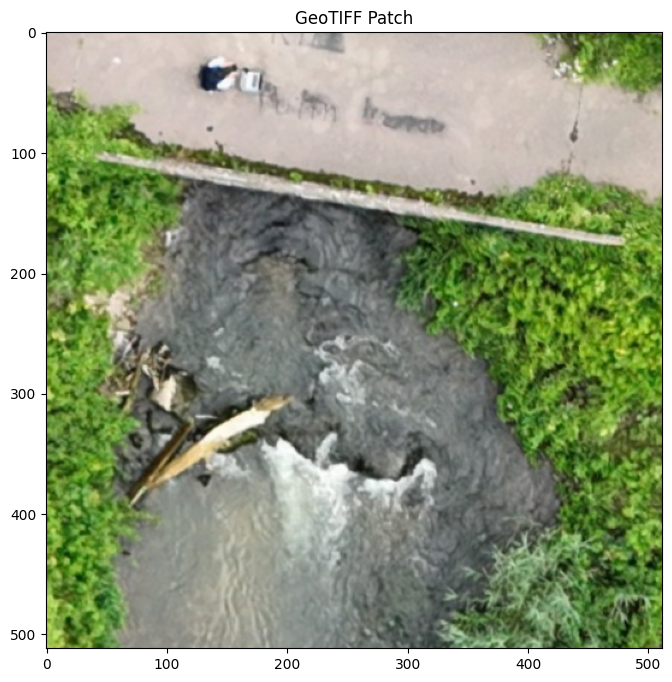

In [184]:
#################################### test GeoTIFF patch path
patch_path_gtif = output_gtif_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.tif"

# load test GeoTIFF patch and plot the image data (RGB = first three bands)
with rasterio.open(patch_path_gtif) as src:
    
    # GeoTIFF data
    ###############################################################
    patch_data_gtif = src.read([1, 2, 3])
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(patch_data_gtif.transpose(1, 2, 0))  # transpose for RGB
    ax.set_title("GeoTIFF Patch")
    plt.show()

2. Plot the image data of a patch saved as NumpyArray

In [185]:
# NumpyArray patch path
patch_path_npy = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (dtype = object > saved as dictionary)
# Data:
###########################################################
patch_data_npy = np.load(patch_path_npy, allow_pickle=True)
###########################################################

# load the image data of the NumpyArray
# Image Data:
###########################################################
patch_image_data_npy = patch_data_npy.item().get("image") # key "image"
# patch_image_data_npy
###########################################################

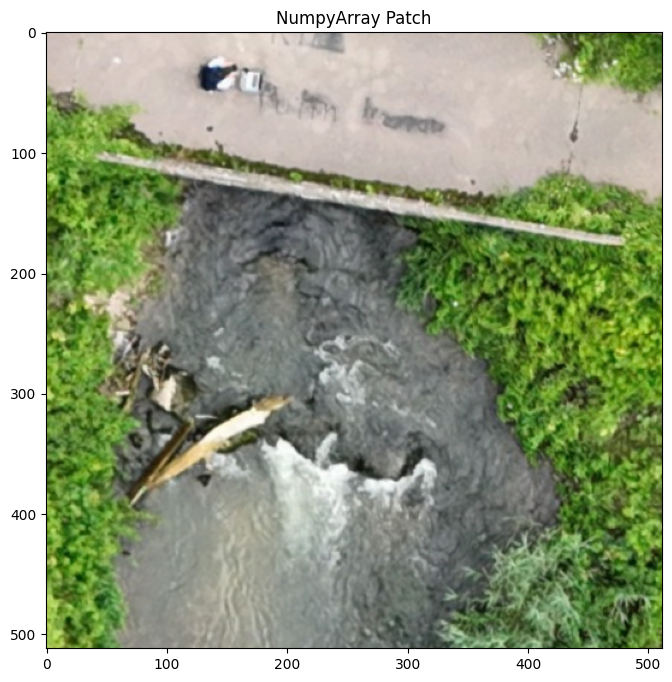

In [186]:
# plot the image data
##################################################
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(patch_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("NumpyArray Patch")
plt.show()

3. Plot NumpyArray masks (if existent) 

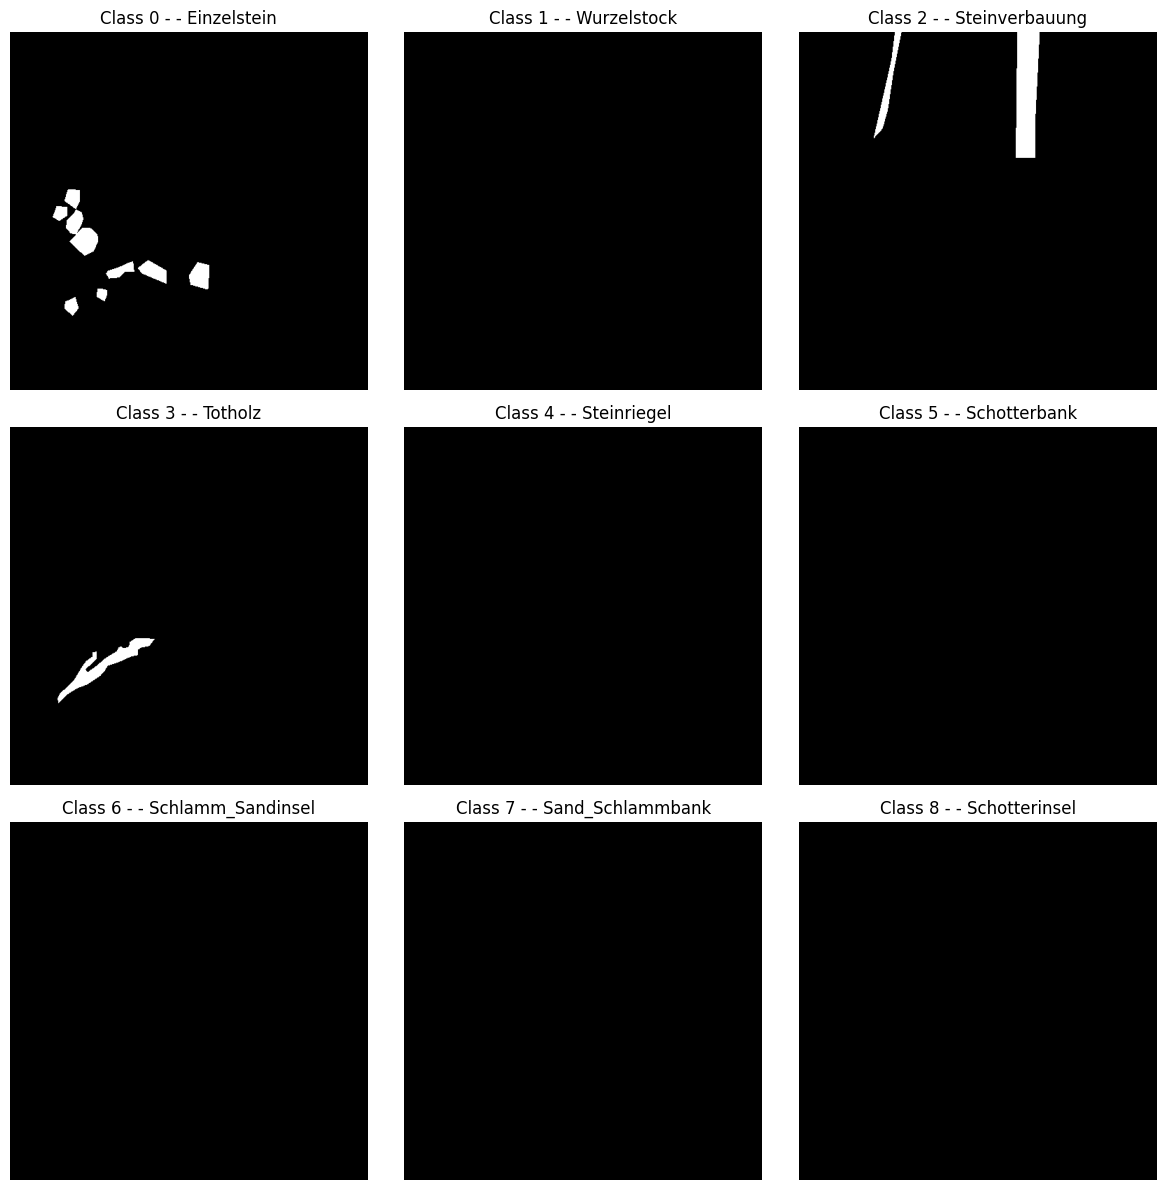

In [187]:
try: 
    # path to numpy mask
    mask_path_npy = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.npy"

    # load mask from this path
    # Mask data:
    ###########################################################
    mask_npy = np.load(mask_path_npy, allow_pickle=True) # load NumpyArray
    ###########################################################
    
    # Plot:
    ###########################################################
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
    axes = axes.flatten()  # easier to iterate through

    for i in range(mask_npy.shape[0]):  # iterate through the 9 classes
        axes[i].imshow(mask_npy[i], cmap="gray")
        axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

except:
    print("There aren't any labels in this patch!")



4. Plot mask together with corresponding image data of the patch

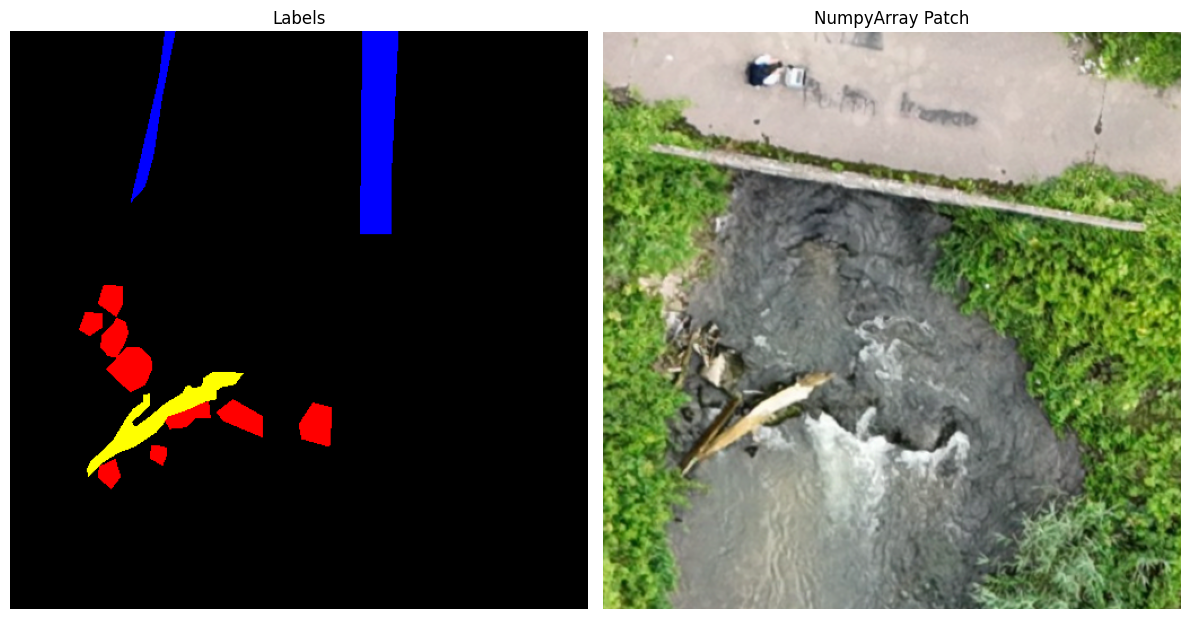

In [188]:
try:
    mask_path_npy = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.npy" # mask path
    mask_npy = np.load(mask_path_npy, allow_pickle=True) # load mask 
    
    # print(mask_npy.shape): (9, 512, 512)
    # create an empty mask with shape (512, 512, 3) > 3 for RGB representation
    combined_mask = np.zeros((mask_npy.shape[1], mask_npy.shape[2], 3), dtype=np.uint8) 

    # rgb-composition per class
    class_colors = [
        [255, 0, 0],    # Klasse 1: Rot
        [0, 255, 0],    # Klasse 2: Grün
        [0, 0, 255],    # Klasse 3: Blau
        [255, 255, 0],  # Klasse 4: Gelb = Totholz z.b.
        [255, 0, 255],  # Klasse 5: Magenta
        [0, 255, 255],  # Klasse 6: Cyan
        [128, 0, 0],    # Klasse 7: Dunkelrot
        [0, 128, 0],    # Klasse 8: Dunkelgrün
        [0, 0, 128],    # Klasse 9: Dunkelblau
    ]

    for i in range(mask_npy.shape[0]):  # iterate through the 9 classes
        class_value = i + 1 # change index to class
        color_mask = np.zeros((mask_npy.shape[1], mask_npy.shape[2], 3), dtype=np.uint8)
        color_mask[mask_npy[i] == 1] = class_colors[i] 
        combined_mask += color_mask 

    fig, axes = plt.subplots(1, 2, figsize=(12, 12))  
   
    axes[0].imshow(combined_mask)
    axes[0].set_title(f"Labels")
    axes[0].axis("off")

    axes[1].imshow(patch_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
    axes[1].set_title("NumpyArray Patch")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

except:
    print("There aren't any labels in this patch!")
    


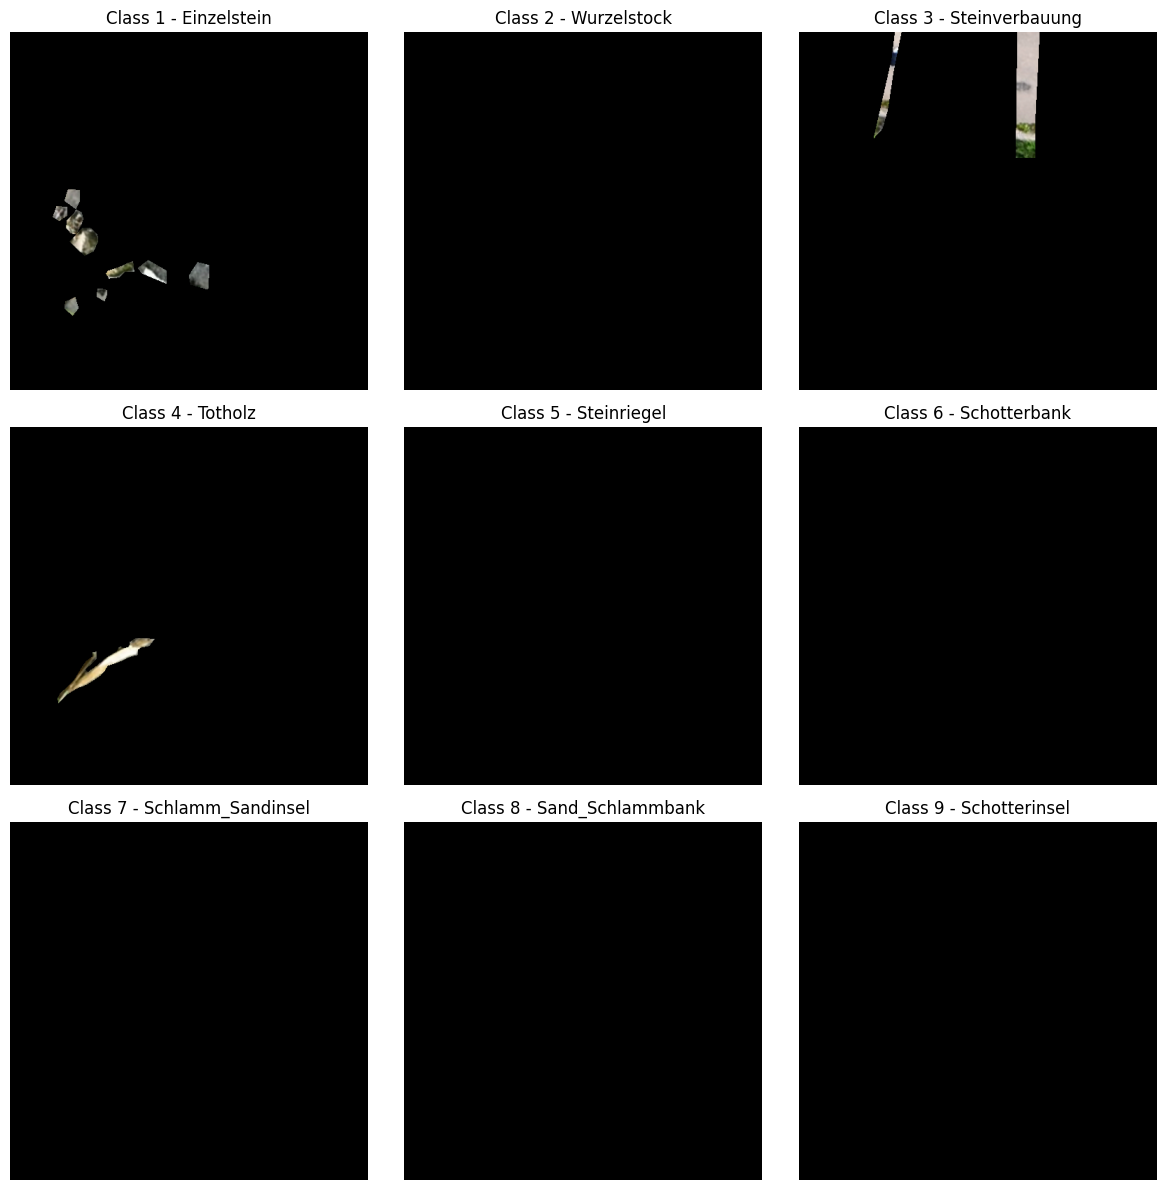

In [189]:
try:
    if mask_npy is not None:
        # Create an empty image to hold the masked areas
        masked_image = np.zeros_like(patch_image_data_npy)  # Empty array with the same shape as the patch image

        # Create a 3x3 grid to display 9 masks
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid for 9 masks
        axes = axes.flatten()  # Easier to iterate through

        for n in range(mask_npy.shape[0]):  # Iterate through all 9 classes
            # Create a mask for the current class
            class_mask = mask_npy[n] > 0  # Boolean mask (true or false) for the current class

            # Apply the mask to all RGB channels
            color_mask = np.zeros_like(patch_image_data_npy)
            for c in range(patch_image_data_npy.shape[0]):  # Apply mask per channel
                color_mask[c][class_mask] = patch_image_data_npy[c][class_mask]

            # Combine the masks for the output
            masked_image = np.maximum(masked_image, color_mask)  # Apply each mask to the image

            # Display the masked image for each class
            axes[n].imshow(color_mask.transpose(1, 2, 0))  # Transpose for RGB representation
            axes[n].set_title(f"Class {n + 1} - {reversed_label_codes[n + 1]}")
            axes[n].axis("off")

        # Optimize layout
        plt.tight_layout()
        plt.show()

    else:
        print("There aren't any labels in this patch!")

except Exception as e:
    print(f"An error occurred: {e}")


5. Plot mask from the GeoTIFF

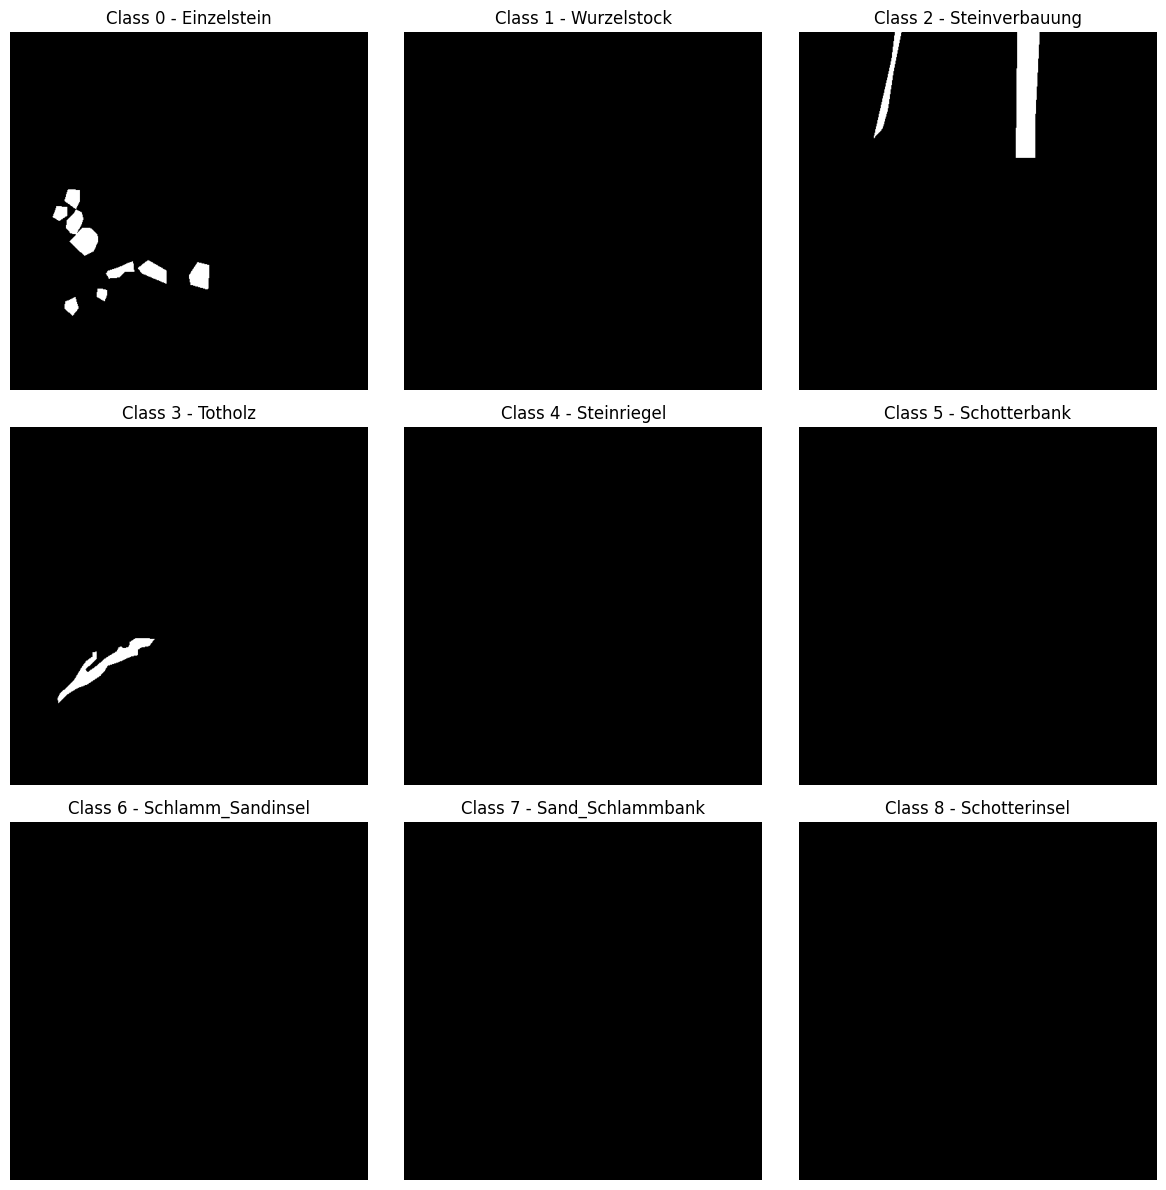

In [190]:
try: 
    mask_path_gtif = output_gtif_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.tif" # mask path

    # load test GeoTIFF patch data
    with rasterio.open(mask_path_gtif) as src:

        # GeoTIFF data
        ###############################################################
        mask_gtif = src.read()
        
        # Plot:
        ###########################################################
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
        axes = axes.flatten()  # easier to iterate through

        for i in range(mask_gtif.shape[0]):  # iterate through the 9 classes
            axes[i].imshow(mask_gtif[i], cmap="gray")
            axes[i].set_title(f"Class {i} - {reversed_label_codes[i + 1]}")
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()
except:
    print("There aren't any labels in this patch!")

### 2.5 OPTIONAL: Check the orthophoto

In [191]:
# check meta data
gtif_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 17270,
 'height': 25023,
 'count': 4,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(3.2633900000001453e-07, 0.0, 11.263241617518593,
        0.0, -2.1580999999988398e-07, 48.750540169360406)}

In [192]:
# check geometrical properties
gtif_crs, gtif_bounds, gtif_height, gtif_width

(CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 BoundingBox(left=11.263241617518593, bottom=48.74513995573041, right=11.268877492048594, top=48.750540169360406),
 25023,
 17270)